# EDA - Datos TCA


### Librerías

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#from sklearn.preprocessing import category_encoders
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
#from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
sns.set_theme(style="darkgrid")
     

In [3]:
pd.set_option('display.max_columns', None)

### Conexión a SQL

In [4]:
host = "localhost"  # e.g., 'localhost' or IP address
port = "5432"       # default PostgreSQL port
database = "postgres"
user = "postgres"
password = "equipo3"


In [5]:
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")
#connection = engine.connect()


### Creación de dataframes

In [126]:
df_ocup = pd.read_sql(f"SELECT * FROM ocupaciones", engine)

(df_ocup == 0).mean()

threshold_zero = 0.9

df_ocup = df_ocup.loc[:, (df_ocup == 0).mean() < threshold_zero]
# Replace empty strings with NaN
df_ocup = df_ocup.replace(r"^\s*$", np.nan, regex=True)



#### Tabla Reservaciones

Contiene detalles de diferentes reservaciones en un periodo de tiempo.

In [119]:
df_resv = pd.read_sql(f"SELECT * FROM reservaciones", engine, index_col='id_reserva')

df_resv.head()

,fecha_hoy,h_res_fec,h_res_fec_ok,h_res_fec_okt,h_num_per,aa_h_num_per,h_num_adu,aa_h_num_adu,h_num_men,aa_h_num_men,h_num_noc,aa_h_num_noc,h_tot_hab,aa_h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_lld_okt,h_fec_reg_ok,h_fec_reg_okt,h_fec_sda_ok,h_fec_sda_okt,id_pais_origen,cliente_disp,aa_cliente_disp,reservacion,aa_reservacion,id_estatus_reservaciones,h_edo,h_nom,h_tfa_total,aa_h_tfa_total,moneda_cve,h_ult_cam_fec_ok,h_ult_cam_fec_okt
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2019-08-16 00:00:00.000,20190816,2019-08-16,2019-08-16 00:00:00.000,2,0,2,0,0,0,3,0,1,0,1,1,14,112,1,25,10,20191107.0,2019-11-07,2019-11-07 00:00:00.000,2019-08-16,2019-08-16 00:00:00.000,2019-11-10,2019-11-10 00:00:00.000,157,2,0,1,0,9,EMX,"QUIROZ, SOFIA",2659.98,0.0,1,2019-11-10,2019-11-10 00:00:00.000
1,2019-10-22 00:00:00.000,20191022,2019-10-22,2019-10-22 00:00:00.000,4,0,4,0,0,0,4,0,1,0,1,2,14,112,1,25,10,20191201.0,2019-12-01,2019-12-01 00:00:00.000,2019-10-22,2019-10-22 00:00:00.000,2019-12-05,2019-12-05 00:00:00.000,157,4,0,1,0,9,EGT,"JIMENEZ, VALENTIN",1764.00,0.0,1,2019-12-05,2019-12-05 00:00:00.000
2,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,2,0,2,0,0,0,4,0,1,0,1,1,14,112,1,23,10,20191201.0,2019-12-01,2019-12-01 00:00:00.000,2019-10-28,2019-10-28 00:00:00.000,2019-12-05,2019-12-05 00:00:00.000,157,2,0,1,0,9,EMC,"GALLEGOS, JORGE ROBERTO",2660.04,0.0,1,2019-12-05,2019-12-05 00:00:00.000
3,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,4,0,3,0,0,0,3,0,1,0,1,2,14,112,1,24,10,20191208.0,2019-12-08,2019-12-08 00:00:00.000,2019-10-28,2019-10-28 00:00:00.000,2019-12-11,2019-12-11 00:00:00.000,157,3,0,1,0,9,EGT,"PEREA, VICTOR HUGO",1995.03,0.0,1,2019-12-11,2019-12-11 00:00:00.000
4,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,2,0,2,0,0,0,4,0,1,0,1,1,5,14,1,4,13,20191208.0,2019-12-08,2019-12-08 00:00:00.000,2019-12-08,2019-12-08 00:00:00.000,2019-12-12,2019-12-12 00:00:00.000,157,2,0,1,0,9,EMX,"TREJO GALVAN, RAMON",13369.92,0.0,1,2019-12-12,2019-12-12 00:00:00.000


In [120]:
def standardize_date(date_column):
    # Convert column to string to handle different formats
    date_column = date_column.astype(str)
    
    # Convert to datetime: auto-parse for common formats
    date_column = pd.to_datetime(date_column, format=None, errors='coerce')
    
    # Format the column to remove the time part
    return date_column.dt.strftime('%Y-%m-%d')


In [121]:
# Apply the standardization function
df_resv['fecha_hoy'] = standardize_date(df_resv['fecha_hoy'])
df_resv['h_res_fec'] = standardize_date(df_resv['h_res_fec'])
df_resv['h_res_fec_ok'] = standardize_date(df_resv['h_res_fec_ok'])
df_resv['h_fec_lld_ok'] = standardize_date(df_resv['h_fec_lld_ok'])
df_resv['h_fec_reg_ok'] = standardize_date(df_resv['h_res_fec'])
df_resv['h_fec_sda_ok'] = standardize_date(df_resv['h_res_fec_ok'])
df_resv['h_ult_cam_fec_ok'] = standardize_date(df_resv['h_ult_cam_fec_ok'])
df_resv = df_resv.drop(columns=['h_res_fec_okt','h_fec_lld_okt',
                                'h_fec_reg_okt','h_fec_sda_okt',
                               'h_ult_cam_fec_okt'])

df_resv['h_fec_lld'] = df_resv['h_fec_lld'].fillna(0)
df_resv['h_fec_lld'] = df_resv['h_fec_lld'].astype(int).astype(str)

# Step 2: Convert to datetime format
df_resv['h_fec_lld'] = pd.to_datetime(df_resv['h_fec_lld'], format='%Y%m%d', errors='coerce')

# List of columns to convert
date_columns = ['h_res_fec', 'h_fec_sda_ok', 'h_ult_cam_fec_ok', 'fecha_hoy']

# Convert columns to datetime format
for col in date_columns:
    df_resv[col] = pd.to_datetime(df_resv[col], errors='coerce')

In [122]:
df_resv.head()

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,aa_h_num_per,h_num_adu,aa_h_num_adu,h_num_men,aa_h_num_men,h_num_noc,aa_h_num_noc,h_tot_hab,aa_h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,aa_cliente_disp,reservacion,aa_reservacion,id_estatus_reservaciones,h_edo,h_nom,h_tfa_total,aa_h_tfa_total,moneda_cve,h_ult_cam_fec_ok
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2019-08-16,2019-08-16,2019-08-16,2,0,2,0,0,0,3,0,1,0,1,1,14,112,1,25,10,2019-11-07,2019-11-07,2019-08-16,2019-08-16,157,2,0,1,0,9,EMX,"QUIROZ, SOFIA",2659.98,0.0,1,2019-11-10
1,2019-10-22,2019-10-22,2019-10-22,4,0,4,0,0,0,4,0,1,0,1,2,14,112,1,25,10,2019-12-01,2019-12-01,2019-10-22,2019-10-22,157,4,0,1,0,9,EGT,"JIMENEZ, VALENTIN",1764.00,0.0,1,2019-12-05
2,2019-10-28,2019-10-28,2019-10-28,2,0,2,0,0,0,4,0,1,0,1,1,14,112,1,23,10,2019-12-01,2019-12-01,2019-10-28,2019-10-28,157,2,0,1,0,9,EMC,"GALLEGOS, JORGE ROBERTO",2660.04,0.0,1,2019-12-05
3,2019-10-28,2019-10-28,2019-10-28,4,0,3,0,0,0,3,0,1,0,1,2,14,112,1,24,10,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,3,0,1,0,9,EGT,"PEREA, VICTOR HUGO",1995.03,0.0,1,2019-12-11
4,2019-10-28,2019-10-28,2019-10-28,2,0,2,0,0,0,4,0,1,0,1,1,5,14,1,4,13,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,2,0,1,0,9,EMX,"TREJO GALVAN, RAMON",13369.92,0.0,1,2019-12-12


In [125]:
# Function to choose the original if changes were made
def original_if_changed(orig, changed):
    return changed if changed != 0 else orig

# Create new columns by combining original and changed values
for col in ['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc', 'h_tot_hab','h_tfa_total','cliente_disp']:
    df_resv[f'{col}'] = df_resv.apply(lambda x: original_if_changed(x[col], x[f'aa_{col}']), axis=1)

# Display the updated DataFrame
df_resv[['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc', 'h_tot_hab']]

,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab
id_reserva,,,,,
0,2,2,0,3,1
1,4,4,0,4,1
2,2,2,0,4,1
3,4,3,0,3,1
4,2,2,0,4,1
...,...,...,...,...,...
202997,2,2,0,3,1
202998,2,2,0,0,1
202999,3,2,0,3,1


In [11]:
reservaciones_por_estatus = df_resv.groupby(['id_estatus_reservaciones', 'reservacion']).size().unstack(fill_value=0)

# Renombrar columnas para mayor claridad
reservaciones_por_estatus.columns = ['No Reservaciones (0)', 'Sí Reservaciones (1)']

# Mostrar el resultado
print(reservaciones_por_estatus)



                          No Reservaciones (0)  Sí Reservaciones (1)
id_estatus_reservaciones                                            
1                                         8100                  9058
2                                        16561                 16740
3                                          927                   927
4                                          293                   293
5                                         9335                  9545
7                                            1                    23
8                                           63                    67
9                                        65523                 65546


In [12]:
df_resv.loc[df_resv['id_estatus_reservaciones'] == 8]

,fecha_hoy,h_res_fec,h_res_fec_ok,h_res_fec_okt,h_num_per,aa_h_num_per,h_num_adu,aa_h_num_adu,h_num_men,aa_h_num_men,h_num_noc,aa_h_num_noc,h_tot_hab,aa_h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_lld_okt,h_fec_reg_ok,h_fec_reg_okt,h_fec_sda_ok,h_fec_sda_okt,id_pais_origen,cliente_disp,aa_cliente_disp,reservacion,aa_reservacion,id_estatus_reservaciones,h_edo,h_nom,h_tfa_total,aa_h_tfa_total,moneda_cve,h_ult_cam_fec_ok,h_ult_cam_fec_okt
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28612,2020-03-03 00:00:00.000,20200303,2020-03-03,2020-03-03 00:00:00.000,1,0,1,0,0,0,3,0,1,0,1,1,17,27,1,24,1,20200712.0,2020-07-12,2020-07-12 00:00:00.000,2020-03-03,2020-03-03 00:00:00.000,2020-07-15,2020-07-15 00:00:00.000,157,1,0,1,0,8,EGT,"ANGUIANO, SARA",7437.00,0.00,1,2020-07-12,2020-07-12 00:00:00.000
28981,2020-01-15 00:00:00.000,20200115,2020-01-15,2020-01-15 00:00:00.000,3,0,3,0,0,0,7,0,1,0,1,1,14,112,1,23,10,20200711.0,2020-07-11,2020-07-11 00:00:00.000,2020-01-15,2020-01-15 00:00:00.000,2020-07-18,2020-07-18 00:00:00.000,157,3,0,1,0,8,EGT,"MARENTES, NORBERTO",9180.01,0.00,1,2020-07-11,2020-07-11 00:00:00.000
28982,2020-01-15 00:00:00.000,20200115,2020-01-15,2020-01-15 00:00:00.000,3,0,3,0,0,0,7,0,1,0,1,1,14,112,1,25,10,20200711.0,2020-07-11,2020-07-11 00:00:00.000,2020-01-15,2020-01-15 00:00:00.000,2020-07-18,2020-07-18 00:00:00.000,157,3,0,1,0,8,EGT,"MARENTES, NORBERTO",6100.01,0.00,1,2020-07-11,2020-07-11 00:00:00.000
29689,2020-03-18 00:00:00.000,20200318,2020-03-18,2020-03-18 00:00:00.000,1,0,1,0,0,0,3,0,1,0,1,1,13,33,1,4,4,20200711.0,2020-07-11,2020-07-11 00:00:00.000,2020-03-18,2020-03-18 00:00:00.000,2020-07-14,2020-07-14 00:00:00.000,157,1,0,1,0,8,EHG,"GARCIA, ADRIANA",6897.00,0.00,1,2020-07-12,2020-07-12 00:00:00.000
29695,2020-03-18 00:00:00.000,20200318,2020-03-18,2020-03-18 00:00:00.000,2,0,2,0,0,0,3,0,1,0,1,1,13,33,1,6,4,20200711.0,2020-07-11,2020-07-11 00:00:00.000,2020-03-18,2020-03-18 00:00:00.000,2020-07-14,2020-07-14 00:00:00.000,157,2,0,1,0,8,EHG,"VIDAL, EZEQUIEL",9894.00,0.00,1,2020-07-11,2020-07-11 00:00:00.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154057,2021-01-24 00:00:00.000,20200124,2020-01-24,2020-01-24 00:00:00.000,0,2,0,2,0,0,0,7,0,1,1,1,14,112,1,23,10,20200711.0,2020-07-11,2020-07-11 00:00:00.000,2020-01-24,2020-01-24 00:00:00.000,2020-07-18,2020-07-18 00:00:00.000,157,0,2,0,1,8,EMC,"ALARCON, ELIZABETH",0.00,6129.97,1,2020-07-12,2020-07-12 00:00:00.000
154058,2021-01-24 00:00:00.000,20200124,2020-01-24,2020-01-24 00:00:00.000,0,1,0,1,0,0,0,7,0,1,1,1,14,112,1,25,10,20200711.0,2020-07-11,2020-07-11 00:00:00.000,2020-01-24,2020-01-24 00:00:00.000,2020-07-18,2020-07-18 00:00:00.000,157,0,1,0,1,8,EMC,"ALARCON, ELIZABETH",0.00,6129.97,1,2020-07-12,2020-07-12 00:00:00.000
154059,2021-01-24 00:00:00.000,20200124,2020-01-24,2020-01-24 00:00:00.000,0,2,0,2,0,0,0,7,0,1,1,1,14,112,1,27,10,20200711.0,2020-07-11,2020-07-11 00:00:00.000,2020-01-24,2020-01-24 00:00:00.000,2020-07-18,2020-07-18 00:00:00.000,157,0,2,0,1,8,EGR,"ALARCON, ELIZABETH",0.00,7024.99,1,2020-07-12,2020-07-12 00:00:00.000


### Manejar valores 0 o vacíos


En la visualización del dataframe observamos que tenemos muchas columnas con valores 0 o vacíos.

Tabla reservaciones

In [128]:
# Proporción de 0 en las columnas
(df_resv == 0).mean()

fecha_hoy                   0.000000
h_res_fec                   0.000000
h_res_fec_ok                0.000000
h_num_per                   0.000000
aa_h_num_per                0.503438
h_num_adu                   0.000000
aa_h_num_adu                0.503438
h_num_men                   0.955050
aa_h_num_men                0.977655
h_num_noc                   0.002000
aa_h_num_noc                0.504438
h_tot_hab                   0.002424
aa_h_tot_hab                0.504650
id_programa                 0.002424
id_paquete                  0.002424
id_segmento_comp            0.002847
id_agencia                  0.000000
id_empresa                  0.000000
id_tipo_habitacion          0.000049
id_canal                    0.031418
h_fec_lld                   0.000000
h_fec_lld_ok                0.000000
h_fec_reg_ok                0.000000
h_fec_sda_ok                0.000000
id_pais_origen              0.003182
cliente_disp                0.000000
aa_cliente_disp             0.503438
r

In [129]:
# Replace empty strings with NaN
df_resv = df_resv.replace(r"^\s*$", np.nan, regex=True)

# Count NaN values after replacing empty strings
df_resv.isnull().sum()

fecha_hoy                   0
h_res_fec                   0
h_res_fec_ok                0
h_num_per                   0
aa_h_num_per                0
h_num_adu                   0
aa_h_num_adu                0
h_num_men                   0
aa_h_num_men                0
h_num_noc                   0
aa_h_num_noc                0
h_tot_hab                   0
aa_h_tot_hab                0
id_programa                 0
id_paquete                  0
id_segmento_comp            0
id_agencia                  0
id_empresa                  0
id_tipo_habitacion          0
id_canal                    0
h_fec_lld                   2
h_fec_lld_ok                0
h_fec_reg_ok                0
h_fec_sda_ok                0
id_pais_origen              0
cliente_disp                0
aa_cliente_disp             0
reservacion                 0
aa_reservacion              0
id_estatus_reservaciones    0
h_edo                       2
h_nom                       0
h_tfa_total                 0
aa_h_tfa_t

## Manejar columnas repetitivas o que no nos sirven

In [102]:
df_resv.head()

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,aa_h_num_per,h_num_adu,aa_h_num_adu,h_num_men,aa_h_num_men,h_num_noc,aa_h_num_noc,h_tot_hab,aa_h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,aa_cliente_disp,reservacion,aa_reservacion,id_estatus_reservaciones,h_edo,h_nom,h_tfa_total,aa_h_tfa_total,moneda_cve,h_ult_cam_fec_ok
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2019-08-16,2019-08-16,2019-08-16,2,0,2,0,0,0,3,0,1,0,1,1,14,112,1,25,10,2019-11-07,2019-11-07,2019-08-16,2019-08-16,157,2,0,1,0,9,EMX,"QUIROZ, SOFIA",2659.98,0.0,1,2019-11-10
1,2019-10-22,2019-10-22,2019-10-22,4,0,4,0,0,0,4,0,1,0,1,2,14,112,1,25,10,2019-12-01,2019-12-01,2019-10-22,2019-10-22,157,4,0,1,0,9,EGT,"JIMENEZ, VALENTIN",1764.00,0.0,1,2019-12-05
2,2019-10-28,2019-10-28,2019-10-28,2,0,2,0,0,0,4,0,1,0,1,1,14,112,1,23,10,2019-12-01,2019-12-01,2019-10-28,2019-10-28,157,2,0,1,0,9,EMC,"GALLEGOS, JORGE ROBERTO",2660.04,0.0,1,2019-12-05
3,2019-10-28,2019-10-28,2019-10-28,4,0,3,0,0,0,3,0,1,0,1,2,14,112,1,24,10,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,3,0,1,0,9,EGT,"PEREA, VICTOR HUGO",1995.03,0.0,1,2019-12-11
4,2019-10-28,2019-10-28,2019-10-28,2,0,2,0,0,0,4,0,1,0,1,1,5,14,1,4,13,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,2,0,1,0,9,EMX,"TREJO GALVAN, RAMON",13369.92,0.0,1,2019-12-12


In [103]:
df_resv.tail()

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,aa_h_num_per,h_num_adu,aa_h_num_adu,h_num_men,aa_h_num_men,h_num_noc,aa_h_num_noc,h_tot_hab,aa_h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,aa_cliente_disp,reservacion,aa_reservacion,id_estatus_reservaciones,h_edo,h_nom,h_tfa_total,aa_h_tfa_total,moneda_cve,h_ult_cam_fec_ok
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202997,2020-04-10,2019-04-10,2019-04-10,2,2,2,2,0,0,3,3,1,1,1,2,14,112,1,19,1,2019-04-10,2019-04-10,2019-04-10,2019-04-10,0,0,2,0,1,2,EMC,"VENEGAS, JOSE",0.0,2659.95,1,2019-04-10
202998,2020-06-17,2019-06-17,2019-06-17,2,2,2,2,0,0,0,0,1,1,1,1,14,112,1,13,1,2019-06-17,2019-06-17,2019-06-17,2019-06-17,0,0,2,0,1,9,EGR,"MEJINEZ, ALFREDO",0.0,171.00,1,2019-06-17
202999,2020-05-30,2019-05-30,2019-05-30,3,3,2,2,0,0,3,3,1,1,1,2,14,112,1,17,1,2019-05-30,2019-05-30,2019-05-30,2019-05-30,0,0,2,0,1,9,EMC,"VELAZQUEZ, JUAN JOSE",0.0,2659.98,1,2019-06-02
203000,2020-08-10,2019-08-10,2019-08-10,2,2,2,2,0,0,2,2,1,1,1,1,5,14,1,6,1,2019-08-10,2019-08-10,2019-08-10,2019-08-10,0,0,2,0,1,9,EMC,"MARTINEZ, RAIMUNDO",0.0,7900.96,1,2019-08-12
203001,2020-02-24,2019-02-24,2019-02-24,2,2,2,2,0,0,4,4,1,1,1,2,14,112,1,25,1,2019-02-24,2019-02-24,2019-02-24,2019-02-24,0,0,2,0,1,9,EMC,"ROJAS, VALENTIN",0.0,2212.00,1,2019-02-28


In [138]:
df_resv = df_resv.drop(columns=['aa_reservacion'])

In [132]:
df_resv = df_resv.drop(columns=['h_nom','h_edo'])

Diferentes columnas contienen la fecha u hora, así como repiten datos.

In [130]:
df_resv = df_resv.drop(columns=['aa_h_num_per','aa_h_num_adu','aa_h_num_men','aa_h_num_noc','aa_h_tot_hab','aa_h_tfa_total','aa_cliente_disp'])


df_resv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203002 entries, 0 to 203001
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   fecha_hoy                 203002 non-null  datetime64[ns]
 1   h_res_fec                 203002 non-null  datetime64[ns]
 2   h_res_fec_ok              203002 non-null  object        
 3   h_num_per                 203002 non-null  int64         
 4   h_num_adu                 203002 non-null  int64         
 5   h_num_men                 203002 non-null  int64         
 6   h_num_noc                 203002 non-null  int64         
 7   h_tot_hab                 203002 non-null  int64         
 8   id_programa               203002 non-null  int64         
 9   id_paquete                203002 non-null  int64         
 10  id_segmento_comp          203002 non-null  int64         
 11  id_agencia                203002 non-null  int64         
 12  id_empr

In [16]:
df_resv.head()

,fecha_hoy,h_res_fec,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,id_estatus_reservaciones,h_edo,h_tfa_total,moneda_cve,h_ult_cam_fec_ok
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,
0,2019-08-16 00:00:00.000,20190816,2,2,0,3,1,1,1,14,112,1,25,10,20191107.0,2019-11-10,157,2,1,9,EMX,2659.98,1,2019-11-10
1,2019-10-22 00:00:00.000,20191022,4,4,0,4,1,1,2,14,112,1,25,10,20191201.0,2019-12-05,157,4,1,9,EGT,1764.00,1,2019-12-05
2,2019-10-28 00:00:00.000,20191028,2,2,0,4,1,1,1,14,112,1,23,10,20191201.0,2019-12-05,157,2,1,9,EMC,2660.04,1,2019-12-05
3,2019-10-28 00:00:00.000,20191028,4,3,0,3,1,1,2,14,112,1,24,10,20191208.0,2019-12-11,157,3,1,9,EGT,1995.03,1,2019-12-11
4,2019-10-28 00:00:00.000,20191028,2,2,0,4,1,1,1,5,14,1,4,13,20191208.0,2019-12-12,157,2,1,9,EMX,13369.92,1,2019-12-12


## Descripción

In [105]:
df_resv.describe()

,fecha_hoy,h_res_fec,h_num_per,aa_h_num_per,h_num_adu,aa_h_num_adu,h_num_men,aa_h_num_men,h_num_noc,aa_h_num_noc,h_tot_hab,aa_h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_sda_ok,id_pais_origen,reservacion,id_estatus_reservaciones,h_tfa_total,aa_h_tfa_total,moneda_cve,h_ult_cam_fec_ok
count,203002,203002,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.000000,203002.0,203002.000000,203002.000000,203000,203002,203002.000000,203002.000000,203002.000000,2.030020e+05,2.030020e+05,203002.0,203002
mean,2020-02-09 22:16:54.161436928,2019-08-12 06:42:02.386971392,2.356415,1.170550,2.174402,1.079694,0.067842,0.033734,3.336071,1.656043,1.004167,0.498586,0.997576,1.417139,13.205057,72.992059,1.0,13.722382,3.516029,2019-11-04 20:45:56.429556736,2019-08-12 06:42:02.386971392,156.597275,0.503438,6.733407,4.106728e+03,4.039369e+03,1.0,2019-09-14 21:58:27.996965888
min,2019-01-02 00:00:00,2019-01-02 00:00:00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,2019-02-05 00:00:00,2019-01-02 00:00:00,0.000000,0.000000,1.000000,-3.091000e+04,-3.091000e+04,1.0,2000-01-01 00:00:00
25%,2019-07-19 00:00:00,2019-04-10 00:00:00,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,11.000000,33.000000,1.0,4.000000,1.000000,2019-06-16 00:00:00,2019-04-10 00:00:00,157.000000,0.000000,3.000000,0.000000e+00,0.000000e+00,1.0,2019-06-09 00:00:00
50%,2020-02-22 00:00:00,2019-07-19 00:00:00,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,1.000000,16.000000,89.000000,1.0,17.000000,4.000000,2019-10-18 00:00:00,2019-07-19 00:00:00,157.000000,1.000000,9.000000,0.000000e+00,0.000000e+00,1.0,2019-10-04 00:00:00
75%,2020-07-17 00:00:00,2019-12-27 00:00:00,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,4.000000,3.000000,1.000000,1.000000,1.000000,2.000000,17.000000,99.000000,1.0,19.000000,4.000000,2020-02-24 00:00:00,2019-12-27 00:00:00,157.000000,1.000000,9.000000,7.592000e+03,7.494000e+03,1.0,2020-01-25 00:00:00
max,2021-04-04 00:00:00,2020-04-30 00:00:00,32.000000,32.000000,15.000000,15.000000,15.000000,15.000000,687.000000,687.000000,6.000000,6.000000,1.000000,5.000000,19.000000,132.000000,1.0,27.000000,13.000000,2021-12-02 00:00:00,2020-04-30 00:00:00,232.000000,1.000000,9.000000,1.033056e+06,1.033056e+06,1.0,2020-07-13 00:00:00
std,NaN,NaN,0.985527,1.368073,0.737840,1.204694,0.371136,0.264043,3.280470,2.847958,0.115038,0.508489,0.049171,0.503859,4.869281,37.254861,0.0,7.646870,2.984189,NaN,NaN,10.558056,0.499989,3.193774,6.501707e+03,6.443027e+03,0.0,NaN


In [106]:
df_resv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203002 entries, 0 to 203001
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   fecha_hoy                 203002 non-null  datetime64[ns]
 1   h_res_fec                 203002 non-null  datetime64[ns]
 2   h_res_fec_ok              203002 non-null  object        
 3   h_num_per                 203002 non-null  int64         
 4   aa_h_num_per              203002 non-null  int64         
 5   h_num_adu                 203002 non-null  int64         
 6   aa_h_num_adu              203002 non-null  int64         
 7   h_num_men                 203002 non-null  int64         
 8   aa_h_num_men              203002 non-null  int64         
 9   h_num_noc                 203002 non-null  int64         
 10  aa_h_num_noc              203002 non-null  int64         
 11  h_tot_hab                 203002 non-null  int64         
 12  aa_h_to

In [133]:
df_resv.head(10)

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,aa_reservacion,id_estatus_reservaciones,h_tfa_total,moneda_cve,h_ult_cam_fec_ok
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2019-08-16,2019-08-16,2019-08-16,2,2,0,3,1,1,1,14,112,1,25,10,2019-11-07,2019-11-07,2019-08-16,2019-08-16,157,2,1,0,9,2659.98,1,2019-11-10
1,2019-10-22,2019-10-22,2019-10-22,4,4,0,4,1,1,2,14,112,1,25,10,2019-12-01,2019-12-01,2019-10-22,2019-10-22,157,4,1,0,9,1764.00,1,2019-12-05
2,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,14,112,1,23,10,2019-12-01,2019-12-01,2019-10-28,2019-10-28,157,2,1,0,9,2660.04,1,2019-12-05
3,2019-10-28,2019-10-28,2019-10-28,4,3,0,3,1,1,2,14,112,1,24,10,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,3,1,0,9,1995.03,1,2019-12-11
4,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,5,14,1,4,13,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,2,1,0,9,13369.92,1,2019-12-12
5,2019-08-05,2019-08-05,2019-08-05,6,6,0,4,1,1,1,14,112,1,24,12,2019-12-01,2019-12-01,2019-08-05,2019-08-05,157,6,1,0,9,2660.04,1,2019-12-05
6,2019-07-19,2019-07-19,2019-07-19,2,2,0,3,1,1,1,14,112,1,25,10,2019-08-22,2019-08-22,2019-07-19,2019-07-19,157,2,1,0,2,3331.98,1,2019-07-24
7,2019-07-19,2019-07-19,2019-07-19,2,2,0,2,1,1,1,5,14,1,4,1,2019-08-23,2019-08-23,2019-07-19,2019-07-19,157,2,1,0,9,8809.92,1,2019-08-25
8,2019-07-19,2019-07-19,2019-07-19,3,2,0,4,1,1,2,14,112,1,26,10,2019-08-25,2019-08-25,2019-07-19,2019-07-19,157,2,1,0,9,2548.00,1,2019-08-29


In [134]:
# Derived features
df_resv['days_to_arrival'] = (df_resv['h_fec_lld'] - df_resv['h_res_fec']).dt.days
df_resv['late_booking'] = (df_resv['days_to_arrival'] <= 3).astype(int)
df_resv['weekend_arrival'] = df_resv['h_fec_lld'].dt.weekday.isin([5, 6]).astype(int)




In [135]:
# Ensure the column is in datetime format
df_resv['h_res_fec'] = pd.to_datetime(df_resv['h_res_fec'], errors='coerce')

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_resv['reservation_day_of_week'] = df_resv['h_res_fec'].dt.dayofweek


In [136]:
df_resv.head(10)

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,aa_reservacion,id_estatus_reservaciones,h_tfa_total,moneda_cve,h_ult_cam_fec_ok,days_to_arrival,late_booking,weekend_arrival,days_since_last_change,stay_duration,reservation_day_of_week
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2019-08-16,2019-08-16,2019-08-16,2,2,0,3,1,1,1,14,112,1,25,10,2019-11-07,2019-11-07,2019-08-16,2019-08-16,157,2,1,0,9,2659.98,1,2019-11-10,83.0,0,0,3.0,83.0,4
1,2019-10-22,2019-10-22,2019-10-22,4,4,0,4,1,1,2,14,112,1,25,10,2019-12-01,2019-12-01,2019-10-22,2019-10-22,157,4,1,0,9,1764.00,1,2019-12-05,40.0,0,1,4.0,40.0,1
2,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,14,112,1,23,10,2019-12-01,2019-12-01,2019-10-28,2019-10-28,157,2,1,0,9,2660.04,1,2019-12-05,34.0,0,1,4.0,34.0,0
3,2019-10-28,2019-10-28,2019-10-28,4,3,0,3,1,1,2,14,112,1,24,10,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,3,1,0,9,1995.03,1,2019-12-11,41.0,0,1,3.0,41.0,0
4,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,5,14,1,4,13,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,2,1,0,9,13369.92,1,2019-12-12,41.0,0,1,4.0,41.0,0
5,2019-08-05,2019-08-05,2019-08-05,6,6,0,4,1,1,1,14,112,1,24,12,2019-12-01,2019-12-01,2019-08-05,2019-08-05,157,6,1,0,9,2660.04,1,2019-12-05,118.0,0,1,4.0,118.0,0
6,2019-07-19,2019-07-19,2019-07-19,2,2,0,3,1,1,1,14,112,1,25,10,2019-08-22,2019-08-22,2019-07-19,2019-07-19,157,2,1,0,2,3331.98,1,2019-07-24,34.0,0,0,29.0,34.0,4
7,2019-07-19,2019-07-19,2019-07-19,2,2,0,2,1,1,1,5,14,1,4,1,2019-08-23,2019-08-23,2019-07-19,2019-07-19,157,2,1,0,9,8809.92,1,2019-08-25,35.0,0,0,2.0,35.0,4
8,2019-07-19,2019-07-19,2019-07-19,3,2,0,4,1,1,2,14,112,1,26,10,2019-08-25,2019-08-25,2019-07-19,2019-07-19,157,2,1,0,9,2548.00,1,2019-08-29,37.0,0,1,4.0,37.0,4


In [113]:
df_resv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203002 entries, 0 to 203001
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   fecha_hoy                 203002 non-null  datetime64[ns]
 1   h_res_fec                 203002 non-null  datetime64[ns]
 2   h_res_fec_ok              203002 non-null  object        
 3   h_num_per                 203002 non-null  int64         
 4   aa_h_num_per              203002 non-null  int64         
 5   h_num_adu                 203002 non-null  int64         
 6   aa_h_num_adu              203002 non-null  int64         
 7   h_num_men                 203002 non-null  int64         
 8   aa_h_num_men              203002 non-null  int64         
 9   h_num_noc                 203002 non-null  int64         
 10  aa_h_num_noc              203002 non-null  int64         
 11  h_tot_hab                 203002 non-null  int64         
 12  aa_h_to

In [146]:
df_resv=df_resv.drop(['avg_TREVPEC_per_comp_y','avg_ADR_per_room_y','avg_ADR_per_comp_y'], axis=1)
df_resv = df_resv.rename(columns={'avg_ADR_per_comp_x': 'avg_ADR_per_comp'})
df_resv = df_resv.rename(columns={'avg_TREVPEC_per_comp_x': 'avg_TREVPEC_per_comp'})
df_resv = df_resv.rename(columns={'avg_ADR_per_room_x': 'avg_ADR_per_room'})

In [176]:
df_resv.head()

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,ID_Segmento_Comp,id_agencia,id_empresa,ID_Tipo_Habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,id_estatus_reservaciones,h_tfa_total,moneda_cve,h_ult_cam_fec_ok,days_to_arrival,late_booking,weekend_arrival,days_since_last_change,stay_duration,reservation_day_of_week,month,week_of_year,advanced_booking,avg_days_by_room_type,avg_ADR_per_comp,avg_TREVPEC_per_comp,avg_ADR_per_room
0,2019-08-16,2019-08-16,2019-08-16,2,2,0,3,1,1,1,14,112,1,25,10,2019-11-07,2019-11-07,2019-08-16,2019-08-16,157,2,1,9,2659.98,1,2019-11-10,83.0,0,0,3.0,83.0,4,11.0,45,0.0,75.975638,681.213913,639.712705,790.636577
2,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,14,112,1,23,10,2019-12-01,2019-12-01,2019-10-28,2019-10-28,157,2,1,9,2660.04,1,2019-12-05,34.0,0,1,4.0,34.0,0,12.0,48,0.0,77.265838,681.213913,639.712705,725.630026
4,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,5,14,1,4,13,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,2,1,9,13369.92,1,2019-12-12,41.0,0,1,4.0,41.0,0,12.0,49,0.0,84.582809,720.893346,661.431288,895.168891
7,2019-07-19,2019-07-19,2019-07-19,2,2,0,2,1,1,1,5,14,1,4,1,2019-08-23,2019-08-23,2019-07-19,2019-07-19,157,2,1,9,8809.92,1,2019-08-25,35.0,0,0,2.0,35.0,4,8.0,34,0.0,84.582809,720.893346,661.431288,895.168891
9,2019-05-06,2019-05-06,2019-05-06,2,2,0,4,1,1,2,14,112,1,27,10,2019-08-25,2019-08-25,2019-05-06,2019-05-06,157,2,1,9,2548.00,1,2019-08-29,111.0,0,1,4.0,111.0,0,8.0,34,0.0,97.992915,681.213913,639.712705,848.665920


In [181]:
df_resv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80952 entries, 0 to 203001
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   fecha_hoy                 80952 non-null  datetime64[ns]
 1   h_res_fec                 80952 non-null  datetime64[ns]
 2   h_res_fec_ok              80952 non-null  object        
 3   h_num_per                 80952 non-null  int64         
 4   h_num_adu                 80952 non-null  int64         
 5   h_num_men                 80952 non-null  int64         
 6   h_num_noc                 80952 non-null  int64         
 7   h_tot_hab                 80952 non-null  int64         
 8   id_programa               80952 non-null  int64         
 9   id_paquete                80952 non-null  int64         
 10  ID_Segmento_Comp          80952 non-null  int64         
 11  id_agencia                80952 non-null  int64         
 12  id_empresa            

In [187]:
df_resv[(df_resv['is_no_show']==1)]

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,ID_Segmento_Comp,id_agencia,id_empresa,ID_Tipo_Habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,id_estatus_reservaciones,h_tfa_total,moneda_cve,h_ult_cam_fec_ok,days_to_arrival,late_booking,weekend_arrival,days_since_last_change,stay_duration,reservation_day_of_week,month,week_of_year,advanced_booking,avg_days_by_room_type,avg_ADR_per_comp,avg_TREVPEC_per_comp,avg_ADR_per_room,days_btwn_change_arrival,is_no_show
102280,2020-11-27,2019-11-27,2019-11-27,2,2,0,2,1,1,1,17,27,1,4,4,2019-12-06,2019-12-06,2019-11-27,2019-11-27,157,2,0,9,6076.00,1,2019-12-06,9.0,0,0,0.0,9.0,2,12.0,49,0.0,84.582809,1424.871347,1407.503177,895.168891,0,1
102281,2020-11-27,2019-11-27,2019-11-27,2,2,0,2,1,1,1,17,27,1,4,4,2019-12-06,2019-12-06,2019-11-27,2019-11-27,157,2,0,9,6076.00,1,2019-12-06,9.0,0,0,0.0,9.0,2,12.0,49,0.0,84.582809,1424.871347,1407.503177,895.168891,0,1
102282,2020-11-27,2019-11-27,2019-11-27,2,2,0,2,1,1,1,17,27,1,4,4,2019-12-06,2019-12-06,2019-11-27,2019-11-27,157,2,0,9,6076.00,1,2019-12-06,9.0,0,0,0.0,9.0,2,12.0,49,0.0,84.582809,1424.871347,1407.503177,895.168891,0,1
102283,2020-11-27,2019-11-27,2019-11-27,2,2,0,2,1,1,1,17,27,1,5,4,2019-12-06,2019-12-06,2019-11-27,2019-11-27,157,2,0,9,6076.00,1,2019-12-06,9.0,0,0,0.0,9.0,2,12.0,49,0.0,61.419143,1424.871347,1407.503177,583.446328,0,1
102393,2020-12-02,2019-12-02,2019-12-02,2,2,0,2,1,1,1,1,32,1,6,1,2019-12-06,2019-12-06,2019-12-02,2019-12-02,157,2,0,9,0.00,1,2019-12-06,4.0,0,0,0.0,4.0,0,12.0,49,0.0,50.101797,1174.575469,1194.703323,812.955911,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202989,2020-03-07,2019-03-07,2019-03-07,2,2,0,1,1,1,2,18,116,1,13,4,2019-03-07,2019-03-07,2019-03-07,2019-03-07,38,2,0,9,128.00,1,2019-03-07,0.0,1,0,0.0,0.0,3,3.0,10,0.0,55.171869,653.555937,660.087140,573.976226,0,1
202990,2020-03-07,2019-03-07,2019-03-07,2,2,0,1,1,1,2,18,116,1,22,4,2019-03-07,2019-03-07,2019-03-07,2019-03-07,38,2,0,9,128.00,1,2019-03-07,0.0,1,0,0.0,0.0,3,3.0,10,0.0,52.181661,653.555937,660.087140,716.010544,0,1
202996,2020-04-10,2019-04-10,2019-04-10,2,2,0,3,1,1,2,14,112,1,19,1,2019-04-10,2019-04-10,2019-04-10,2019-04-10,0,2,0,2,2659.95,1,2019-04-10,0.0,1,0,0.0,0.0,2,4.0,15,0.0,120.169790,681.213913,639.712705,813.625894,0,1
202997,2020-04-10,2019-04-10,2019-04-10,2,2,0,3,1,1,2,14,112,1,19,1,2019-04-10,2019-04-10,2019-04-10,2019-04-10,0,2,0,2,2659.95,1,2019-04-10,0.0,1,0,0.0,0.0,2,4.0,15,0.0,120.169790,681.213913,639.712705,813.625894,0,1


In [186]:
import pandas as pd

# Sample data conversion, adapt column names and formats as necessary
df_resv['h_fec_lld_ok'] = pd.to_datetime(df_resv['h_fec_lld_ok'], errors='coerce')  # Use 'coerce' to handle any non-conformable values
df_resv['h_ult_cam_fec_ok'] = pd.to_datetime(df_resv['h_ult_cam_fec_ok'], errors='coerce')

# Calculate the difference in days between arrival and last change
df_resv['days_btwn_change_arrival'] = abs((df_resv['h_fec_lld_ok'] - df_resv['h_ult_cam_fec_ok']).dt.days)

# Create a binary target: 1 if days_between is 0, else 0 (you might have actual no-show data to use here)
df_resv['is_no_show'] = ((df_resv['days_btwn_change_arrival']==0) & (df_resv['reservacion']==0)).astype(int)

df_resv.head()

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,ID_Segmento_Comp,id_agencia,id_empresa,ID_Tipo_Habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,id_estatus_reservaciones,h_tfa_total,moneda_cve,h_ult_cam_fec_ok,days_to_arrival,late_booking,weekend_arrival,days_since_last_change,stay_duration,reservation_day_of_week,month,week_of_year,advanced_booking,avg_days_by_room_type,avg_ADR_per_comp,avg_TREVPEC_per_comp,avg_ADR_per_room,days_btwn_change_arrival,is_no_show
0,2019-08-16,2019-08-16,2019-08-16,2,2,0,3,1,1,1,14,112,1,25,10,2019-11-07,2019-11-07,2019-08-16,2019-08-16,157,2,1,9,2659.98,1,2019-11-10,83.0,0,0,3.0,83.0,4,11.0,45,0.0,75.975638,681.213913,639.712705,790.636577,3,0
2,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,14,112,1,23,10,2019-12-01,2019-12-01,2019-10-28,2019-10-28,157,2,1,9,2660.04,1,2019-12-05,34.0,0,1,4.0,34.0,0,12.0,48,0.0,77.265838,681.213913,639.712705,725.630026,4,0
4,2019-10-28,2019-10-28,2019-10-28,2,2,0,4,1,1,1,5,14,1,4,13,2019-12-08,2019-12-08,2019-10-28,2019-10-28,157,2,1,9,13369.92,1,2019-12-12,41.0,0,1,4.0,41.0,0,12.0,49,0.0,84.582809,720.893346,661.431288,895.168891,4,0
7,2019-07-19,2019-07-19,2019-07-19,2,2,0,2,1,1,1,5,14,1,4,1,2019-08-23,2019-08-23,2019-07-19,2019-07-19,157,2,1,9,8809.92,1,2019-08-25,35.0,0,0,2.0,35.0,4,8.0,34,0.0,84.582809,720.893346,661.431288,895.168891,2,0
9,2019-05-06,2019-05-06,2019-05-06,2,2,0,4,1,1,2,14,112,1,27,10,2019-08-25,2019-08-25,2019-05-06,2019-05-06,157,2,1,9,2548.00,1,2019-08-29,111.0,0,1,4.0,111.0,0,8.0,34,0.0,97.992915,681.213913,639.712705,848.665920,4,0


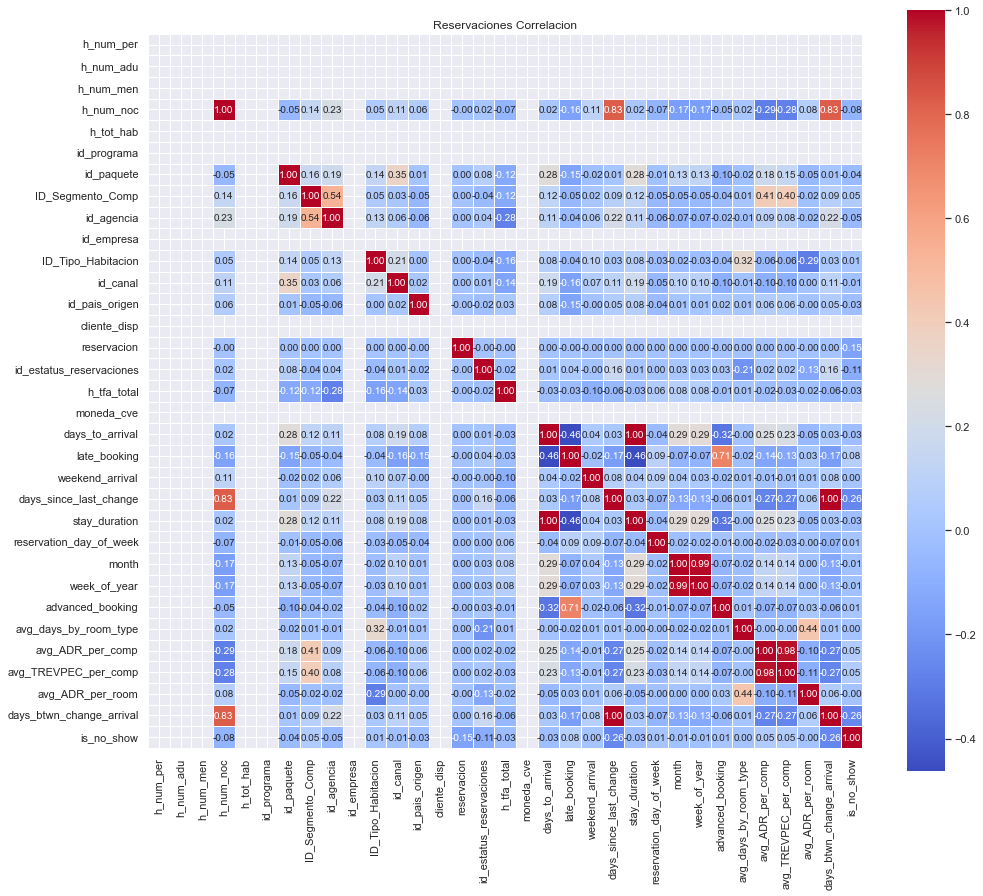

In [188]:
corr_resv = df_resv.corr(numeric_only=True)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_resv, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Reservaciones Correlacion')
plt.show()

In [30]:
df_resv[df_resv['reservacion']==0]

,fecha_hoy,h_res_fec,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,id_segmento_comp,id_agencia,id_empresa,id_tipo_habitacion,id_canal,h_fec_lld,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,id_estatus_reservaciones,h_edo,h_tfa_total,moneda_cve,h_ult_cam_fec_ok,days_to_arrival,late_booking,weekend_arrival,days_since_last_change,stay_duration,reservation_day_of_week
id_reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
102199,2020-08-16,2019-08-16,0,0,0,0,0,1,1,14,112,1,25,10,2019-11-07,2019-11-10,157,0,0,9,EMX,0.0,1,2019-11-10,83.0,0,0,86,3.0,4
102200,2020-10-22,2019-10-22,0,0,0,0,0,1,2,14,112,1,25,10,2019-12-01,2019-12-05,157,0,0,9,EGT,0.0,1,2019-12-05,40.0,0,1,44,4.0,1
102201,2020-10-28,2019-10-28,0,0,0,0,0,1,1,14,112,1,23,10,2019-12-01,2019-12-05,157,0,0,9,EMC,0.0,1,2019-12-05,34.0,0,1,38,4.0,0
102202,2020-10-28,2019-10-28,0,0,0,0,0,1,2,14,112,1,24,10,2019-12-08,2019-12-11,157,0,0,9,EGT,0.0,1,2019-12-11,41.0,0,1,44,3.0,0
102203,2020-10-28,2019-10-28,0,0,0,0,0,1,1,5,14,1,4,13,2019-12-08,2019-12-12,157,0,0,9,EMX,0.0,1,2019-12-12,41.0,0,1,45,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202997,2020-04-10,2019-04-10,0,0,0,0,0,1,2,14,112,1,19,1,2019-04-10,2019-04-10,0,0,0,2,EMC,0.0,1,2019-04-10,0.0,1,0,0,0.0,2
202998,2020-06-17,2019-06-17,0,0,0,0,0,1,1,14,112,1,13,1,2019-06-17,2019-06-17,0,0,0,9,EGR,0.0,1,2019-06-17,0.0,1,0,0,0.0,0
202999,2020-05-30,2019-05-30,0,0,0,0,0,1,2,14,112,1,17,1,2019-05-30,2019-06-02,0,0,0,9,EMC,0.0,1,2019-06-02,0.0,1,0,3,3.0,3


In [140]:
import pandas as pd

# Assuming 'arrival_date' is a datetime column in your dataframe
df_resv['month'] = df_resv['h_fec_lld'].dt.month
df_resv['week_of_year'] = df_resv['h_fec_lld'].dt.isocalendar().week
df_resv['advanced_booking'] = df_resv['days_to_arrival'] * df_resv['late_booking']
# Example: Mean days to arrival by room type
avg_days_by_room = df_resv.groupby('id_tipo_habitacion')['days_to_arrival'].mean().to_dict()
df_resv['avg_days_by_room_type'] = df_resv['id_tipo_habitacion'].map(avg_days_by_room)


In [143]:
# Assuming df_ocup and df_resv as your dataframes
df_resv = df_resv.rename(columns={'id_segmento_comp': 'ID_Segmento_Comp'})
df_resv = df_resv.rename(columns={'id_tipo_habitacion': 'ID_Tipo_Habitacion'})




# Calculate average ADR and TREVPEC for each competitive segment in 'Ocupaciones'
avg_metrics = df_ocup.groupby('ID_Segmento_Comp').agg({
    'ADR': 'mean',
    'TREVPEC': 'mean'
}).rename(columns={'ADR': 'avg_ADR_per_comp', 'TREVPEC': 'avg_TREVPEC_per_comp'})

# Merge these averages into 'Reservaciones'
df_resv = df_resv.merge(avg_metrics, on='ID_Segmento_Comp', how='left')

# Calculate average ADR by room type in 'Ocupaciones'
avg_adr_room = df_ocup.groupby('ID_Tipo_Habitacion')['ADR'].mean().rename('avg_ADR_per_room')

# Merge this average into 'Reservaciones'
df_resv = df_resv.merge(avg_adr_room, on='ID_Tipo_Habitacion', how='left')

# Now df_resv contains the new features which can be used for further classification model building.
#df_resv=df_resv.drop(['avg_ADR_per_comp_y','avg_TREVPEC_per_comp_y'], axis=1)
#df_resv = df_resv.rename(columns={'avg_ADR_per_comp_x': 'avg_ADR_per_comp'})
#df_resv = df_resv.rename(columns={'avg_TREVPEC_per_comp_x': 'avg_TREVPEC_per_comp'})

In [ ]:
fecha_hoy	h_res_fec	h_res_fec_ok	h_fec_lld	h_fec_lld_ok	h_fec_reg_ok	h_fec_sda_ok	h_ult_cam_fec_ok

In [150]:
df_resv[df_resv['ID_Tipo_Habitacion']==0]

,fecha_hoy,h_res_fec,h_res_fec_ok,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,ID_Segmento_Comp,id_agencia,id_empresa,ID_Tipo_Habitacion,id_canal,h_fec_lld,h_fec_lld_ok,h_fec_reg_ok,h_fec_sda_ok,id_pais_origen,cliente_disp,reservacion,id_estatus_reservaciones,h_tfa_total,moneda_cve,h_ult_cam_fec_ok,days_to_arrival,late_booking,weekend_arrival,days_since_last_change,stay_duration,reservation_day_of_week,month,week_of_year,advanced_booking,avg_days_by_room_type,avg_ADR_per_comp,avg_TREVPEC_per_comp,avg_ADR_per_room
20667,2019-11-21,2019-11-21,2019-11-21,2,2,0,4,1,1,2,12,56,1,0,4,2020-02-13,2020-02-13,2019-11-21,2019-11-21,157,2,1,3,19120.0,1,2020-02-14,84.0,0,0,1.0,84.0,3,2.0,7,0.0,123.8,789.251163,734.480066,NaN
91539,2019-06-24,2019-06-24,2019-06-24,2,2,0,2,1,1,2,17,99,1,0,4,2019-08-18,2019-08-18,2019-06-24,2019-06-24,157,2,1,5,0.0,1,2019-06-24,55.0,0,1,55.0,55.0,0,8.0,33,0.0,123.8,1424.871347,1407.503177,NaN
97525,2019-06-17,2019-06-17,2019-06-17,2,2,0,3,1,1,2,17,99,1,0,4,2019-11-24,2019-11-24,2019-06-17,2019-06-17,157,2,1,5,0.0,1,2019-06-17,160.0,0,1,160.0,160.0,0,11.0,47,0.0,123.8,1424.871347,1407.503177,NaN
97527,2019-06-17,2019-06-17,2019-06-17,2,2,0,3,1,1,2,17,99,1,0,4,2019-11-24,2019-11-24,2019-06-17,2019-06-17,157,2,1,5,0.0,1,2019-06-17,160.0,0,1,160.0,160.0,0,11.0,47,0.0,123.8,1424.871347,1407.503177,NaN
97528,2019-06-17,2019-06-17,2019-06-17,2,2,0,3,1,1,2,17,99,1,0,4,2019-11-24,2019-11-24,2019-06-17,2019-06-17,157,2,1,5,0.0,1,2019-06-17,160.0,0,1,160.0,160.0,0,11.0,47,0.0,123.8,1424.871347,1407.503177,NaN
122866,2020-11-21,2019-11-21,2019-11-21,2,2,0,4,1,1,2,12,56,1,0,4,2020-02-13,2020-02-13,2019-11-21,2019-11-21,157,2,0,3,19120.0,1,2020-02-14,84.0,0,0,1.0,84.0,3,2.0,7,0.0,123.8,789.251163,734.480066,NaN
193738,2020-06-24,2019-06-24,2019-06-24,2,2,0,2,1,1,2,17,99,1,0,4,2019-08-18,2019-08-18,2019-06-24,2019-06-24,157,2,0,5,0.0,1,2019-06-24,55.0,0,1,55.0,55.0,0,8.0,33,0.0,123.8,1424.871347,1407.503177,NaN
199724,2020-06-17,2019-06-17,2019-06-17,2,2,0,3,1,1,2,17,99,1,0,4,2019-11-24,2019-11-24,2019-06-17,2019-06-17,157,2,0,5,0.0,1,2019-06-17,160.0,0,1,160.0,160.0,0,11.0,47,0.0,123.8,1424.871347,1407.503177,NaN
199726,2020-06-17,2019-06-17,2019-06-17,2,2,0,3,1,1,2,17,99,1,0,4,2019-11-24,2019-11-24,2019-06-17,2019-06-17,157,2,0,5,0.0,1,2019-06-17,160.0,0,1,160.0,160.0,0,11.0,47,0.0,123.8,1424.871347,1407.503177,NaN
199727,2020-06-17,2019-06-17,2019-06-17,2,2,0,3,1,1,2,17,99,1,0,4,2019-11-24,2019-11-24,2019-06-17,2019-06-17,157,2,0,5,0.0,1,2019-06-17,160.0,0,1,160.0,160.0,0,11.0,47,0.0,123.8,1424.871347,1407.503177,NaN


In [206]:
selected_features = ['id_estatus_reservaciones','days_to_arrival','late_booking',
                        'reservation_day_of_week','weekend_arrival','id_paquete','ID_Segmento_Comp',
                     'id_agencia','id_empresa','ID_Tipo_Habitacion','month','week_of_year',
                     'advanced_booking','h_num_per','h_num_adu','h_num_men','h_num_noc','h_tot_hab', 'h_tfa_total', 
                     'avg_ADR_per_comp','avg_TREVPEC_per_comp','avg_ADR_per_room']

categorical_features = ['reservation_day_of_week', 'id_estatus_reservaciones',
                        'late_booking','weekend_arrival','id_paquete','ID_Segmento_Comp','id_agencia',
                        'id_empresa','ID_Tipo_Habitacion','month','week_of_year','advanced_booking']


numerical_features = ['days_to_arrival','h_num_per','h_num_adu','h_num_men',
                        'h_num_noc','h_tot_hab', 'h_tfa_total','avg_ADR_per_comp','avg_TREVPEC_per_comp','avg_ADR_per_room']


In [207]:
def remove_outliers_by_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply only to numerical features
for feature in numerical_features:
    df_resv = remove_outliers_by_iqr(df_resv, feature)


ValueError: num must be an integer with 1 <= num <= 9, not 10

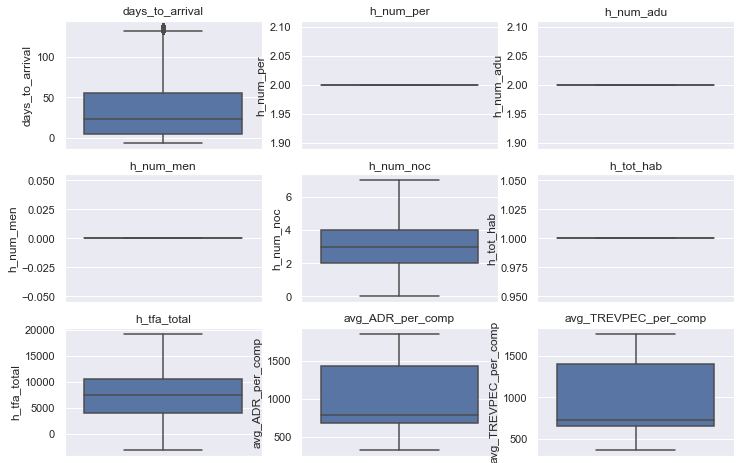

In [208]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df_resv[col])
    plt.title(col)
plt.tight_layout()
plt.show()


In [209]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Define preprocessing for numerical data: scaling
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessing engine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Now you can integrate this `preprocessor` into a full model pipeline if desired


In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_resv[selected_features], df_resv['reservacion'], test_size=0.2, random_state=42)


In [203]:
X = df_resv[selected_features]
y = df_resv['is_no_show']

In [194]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Define the model builder function
def create_model():
    model = Sequential([
        # Ensure the input shape is correctly defined for your data
        Dense(64, activation='relu', input_shape=(input_shape,)),  # `input_shape` should match the number of features after preprocessing
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Prepare data
X = df_resv[selected_features]
y = df_resv['is_no_show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data and find out the input shape
X_train_transformed = preprocessor.fit_transform(X_train)
input_shape = X_train_transformed.shape[1]  # This gives the number of input features after transformation

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=1))
])


In [221]:
df_reservaciones = df_resv

In [230]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Supongamos que df es tu DataFrame

# Mezclar los datos
df_reservaciones = shuffle(df_reservaciones, random_state=42)
drop_columns=['days_btwn_change_arrival','days_since_last_change','reservacion','is_no_show','fecha_hoy','h_res_fec','h_res_fec_ok','h_fec_lld','h_fec_lld_ok','h_fec_reg_ok','h_fec_sda_ok','h_ult_cam_fec_ok']
# Dividir los datos en conjuntos de entrenamiento y prueba con estratificación
X = df_reservaciones.drop(drop_columns, axis=1)  # Asume que 'reservacion' es tu columna objetivo
y = df_reservaciones['is_no_show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la distribución de las clases en los conjuntos de entrenamiento y prueba
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


is_no_show
0    0.978221
1    0.021779
Name: proportion, dtype: float64
is_no_show
0    0.978206
1    0.021794
Name: proportion, dtype: float64


In [231]:
X

,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,id_programa,id_paquete,ID_Segmento_Comp,id_agencia,id_empresa,ID_Tipo_Habitacion,id_canal,id_pais_origen,cliente_disp,id_estatus_reservaciones,h_tfa_total,moneda_cve,days_to_arrival,late_booking,weekend_arrival,stay_duration,reservation_day_of_week,month,week_of_year,advanced_booking,avg_days_by_room_type,avg_ADR_per_comp,avg_TREVPEC_per_comp,avg_ADR_per_room
106947,2,2,0,3,1,1,1,17,26,1,13,1,157,2,2,8634.00,1,12.0,0,0,12.0,4,8.0,35,0.0,55.171869,1424.871347,1407.503177,573.976226
167434,2,2,0,3,1,1,1,16,86,1,4,0,157,2,3,10794.00,1,73.0,0,1,73.0,3,3.0,12,0.0,84.582809,673.807391,664.145183,895.168891
185724,2,2,0,3,1,1,2,14,112,1,25,10,157,2,9,2659.98,1,70.0,0,0,70.0,3,5.0,19,0.0,75.975638,681.213913,639.712705,790.636577
68318,2,2,0,3,1,1,2,12,48,1,2,4,157,2,9,11040.00,1,97.0,0,0,97.0,4,6.0,25,0.0,42.640394,789.251163,734.480066,886.047874
49217,2,2,0,3,1,1,1,17,2,1,13,1,157,2,9,11514.00,1,11.0,0,0,11.0,5,3.0,12,0.0,55.171869,1424.871347,1407.503177,573.976226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84949,2,2,0,3,1,1,1,17,105,1,6,1,157,2,9,13914.00,1,28.0,0,0,28.0,2,11.0,46,0.0,50.101797,1424.871347,1407.503177,812.955911
35341,2,2,0,2,1,1,1,8,12,1,4,7,157,2,9,6440.80,1,7.0,0,1,7.0,6,3.0,12,0.0,84.582809,654.396529,966.205953,895.168891
77020,2,2,0,2,1,1,1,13,33,1,13,4,157,2,9,5396.00,1,91.0,0,0,91.0,4,5.0,22,0.0,55.171869,1034.665673,971.093497,573.976226
42379,2,2,0,4,1,1,1,17,53,1,19,1,157,2,9,11512.00,1,5.0,0,1,5.0,1,6.0,23,0.0,120.169790,1424.871347,1407.503177,813.625894


In [ ]:
df_resv

In [232]:
# Train the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9631080227416298


In [215]:
df_resv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79148 entries, 0 to 203001
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   fecha_hoy                 79148 non-null  datetime64[ns]
 1   h_res_fec                 79148 non-null  datetime64[ns]
 2   h_res_fec_ok              79148 non-null  object        
 3   h_num_per                 79148 non-null  int64         
 4   h_num_adu                 79148 non-null  int64         
 5   h_num_men                 79148 non-null  int64         
 6   h_num_noc                 79148 non-null  int64         
 7   h_tot_hab                 79148 non-null  int64         
 8   id_programa               79148 non-null  int64         
 9   id_paquete                79148 non-null  int64         
 10  ID_Segmento_Comp          79148 non-null  int64         
 11  id_agencia                79148 non-null  int64         
 12  id_empresa            

In [202]:
df_resv['week_of_year'] = df_resv['week_of_year'].astype('int64')

Test Accuracy: 0.9631080227416298
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15485
           1       0.21      0.24      0.22       345

    accuracy                           0.96     15830
   macro avg       0.59      0.61      0.60     15830
weighted avg       0.97      0.96      0.96     15830



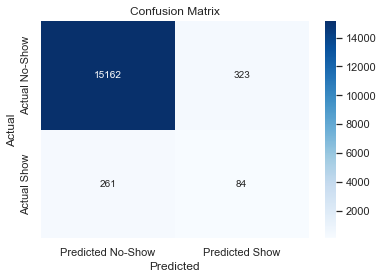

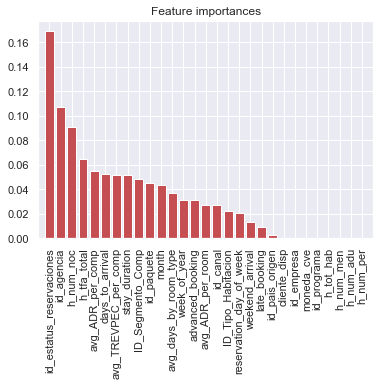

In [233]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a fitted pipeline
# Evaluate the pipeline on the test data
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))

# Generate and display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted No-Show', 'Predicted Show'], yticklabels=['Actual No-Show', 'Actual Show'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance (for models that support this like RandomForest)
if 'RandomForestClassifier' in str(pipeline.named_steps['classifier']):
    importances = pipeline.named_steps['classifier'].feature_importances_
    features = X_train.columns
    indices = np.argsort(importances)[::-1]
    
    # Plot Feature Importance
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()


              precision    recall  f1-score   support

           0       0.17      0.16      0.16      8042
           1       0.17      0.17      0.17      7927

    accuracy                           0.17     15969
   macro avg       0.17      0.17      0.17     15969
weighted avg       0.17      0.17      0.17     15969

Confusion Matrix:


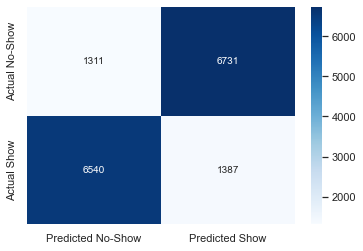

In [205]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create a pipeline with SMOTE and a classifier
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),  # Oversample the minority class
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Split your data into training and testing set if not already done

# Train the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the predictions
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted No-Show', 'Predicted Show'], yticklabels=['Actual No-Show', 'Actual Show'])
plt.show()


In [196]:
# Fit the model
lr_pipeline.fit(X_train, y_train)

# Evaluate the model
print("Test Accuracy:", lr_pipeline.score(X_test, y_test))


Test Accuracy: 0.9768927296637234


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", X_train.shape, "Test set size:", X_test.shape)

In [38]:
# Check correlations for each numerical feature with the target if it's encoded numerically
correlations = df_resv[numerical_features].corrwith(y)
print(correlations)

days_to_arrival           0.009140
days_since_last_change   -0.007358
stay_duration            -0.007220
h_num_men                      NaN
dtype: float64


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm_pipeline, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

In [173]:
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit and evaluate
rf_pipeline.fit(X_train, y_train)
print("Test Accuracy:", rf_pipeline.score(X_test, y_test))


Test Accuracy: 0.17386202211104934


In [171]:
from keras.models import Sequential
from keras.regularizers import l2

model = Sequential()
model.add(Dense(10, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(10, activation="relu", kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [172]:
from keras.callbacks import EarlyStopping

# Setup early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stop])
model.summary()

Epoch 1/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5055 - loss: 143.7305 - val_accuracy: 0.4948 - val_loss: 3.9413
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5000 - loss: 3.1608 - val_accuracy: 0.4922 - val_loss: 3.2199
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5048 - loss: 2.7023 - val_accuracy: 0.4922 - val_loss: 1.2315
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5006 - loss: 2.5779 - val_accuracy: 0.5105 - val_loss: 7.0836
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4996 - loss: 2.2848 - val_accuracy: 0.4901 - val_loss: 1.2376
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4975 - loss: 2.4538 - val_accuracy: 0.5124 - val_loss: 3.8095
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4985 - loss: 2.6119 - val_accuracy: 0.4900 - val_loss: 3.4070
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5008 - loss: 2.2164 

KeyboardInterrupt: 

### Ingresos por Segmento de Mercado de tabla Reservaciones

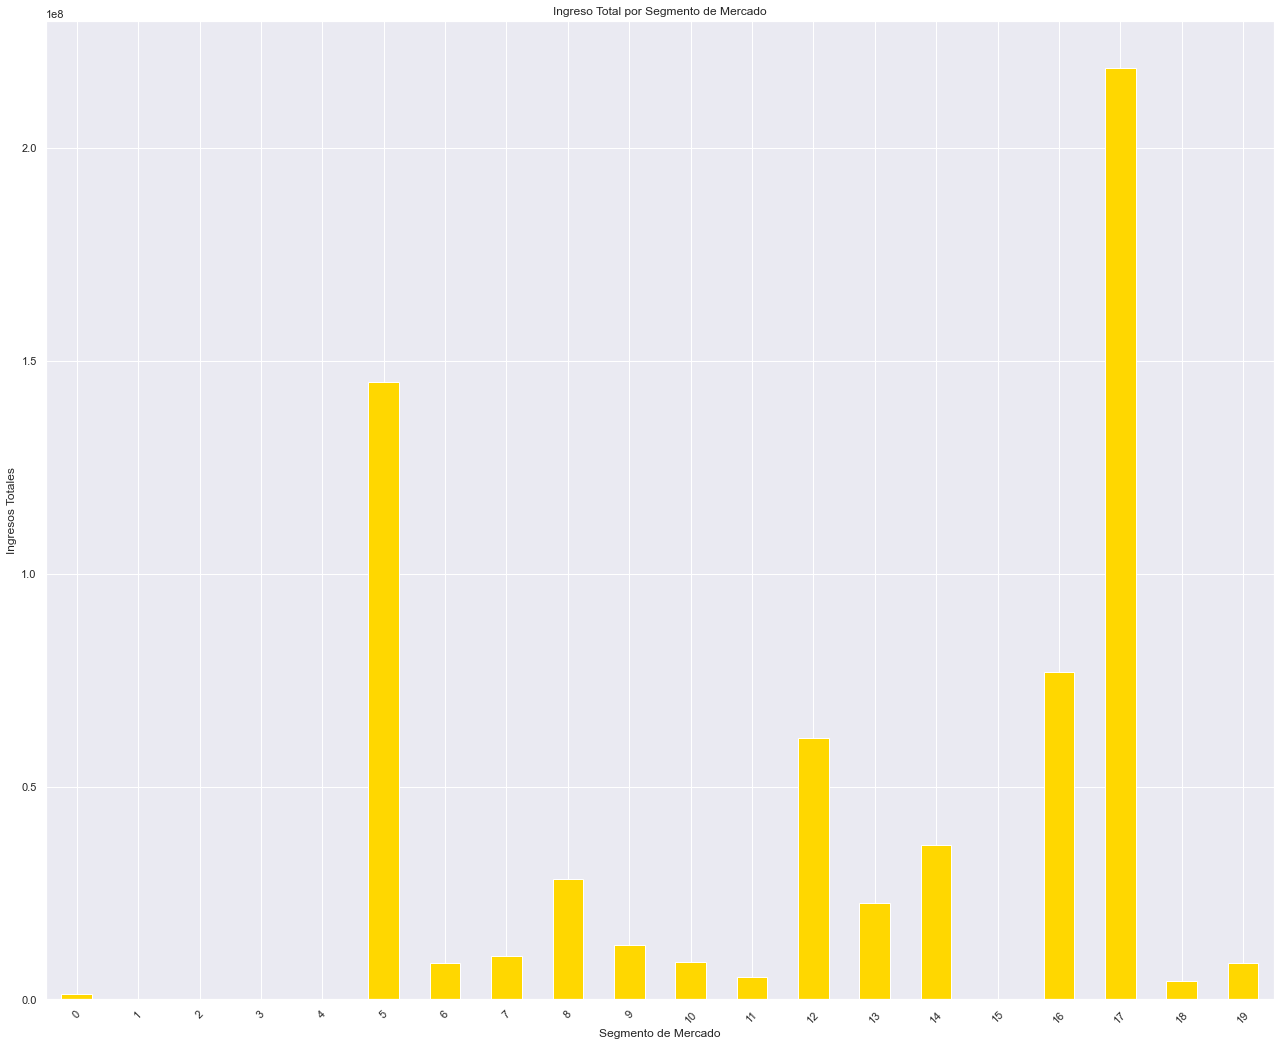

In [64]:

ingresos_segmento = df_resv.groupby("id_segmento_comp")["h_tfa_total"].sum()
plt.figure(figsize=(22, 18))
ingresos_segmento.plot(kind="bar", color="gold")
plt.title("Ingreso Total por Segmento de Mercado")
plt.xlabel("Segmento de Mercado")
plt.ylabel("Ingresos Totales")
plt.xticks(rotation=45)
plt.show()
